### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом(вставить свой) - https://github.com/runnerup96/pytorch-machine-translation

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский. 

In [1]:
!wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip

Archive:  rus-eng.zip


--2024-05-06 21:16:27--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16305013 (16M) [application/zip]
Saving to: ‘rus-eng.zip.1’

     0K .......... .......... .......... .......... ..........  0%  120K 2m12s
    50K .......... .......... .......... .......... ..........  0%  238K 99s
   100K .......... .......... .......... .......... ..........  0%  238K 88s
   150K .......... .......... .......... .......... ..........  1%  172M 66s
   200K .......... .......... .......... .......... ..........  1%  212M 52s
   250K .......... .......... .......... .......... ..........  1%  239K 54s
   300K .......... .......... .......... .......... ..........  2%  195M 47s
   350K .......... .......... .......... .......... ..........  2% 60.8M 41s
   400K .......... .......... .......... 

Exception: Process exited with code 1

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:1024'

In [3]:
import os
import re
import numpy as np
import random

In [4]:
import re
import matplotlib.pylab as plt

MATCH_REGEX = re.compile(r"[+-]?\b(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)\b")

def extract_values(string):
    result = dict()
    params = ['val_loss', 'train_loss', 'bleu_score']
    if "train_loss" in string:
        found_vals = [re_match[0] for re_match in re.findall(MATCH_REGEX, string)]
    
        if len(params) == len(found_vals):
            for name, val in zip(params, found_vals):
                result[name] = float(val)
    return result

def plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    ax1.plot(range(len(train_loss_list)), train_loss_list, label='train loss')
    ax1.plot(range(len(val_loss_list)), val_loss_list, label='val loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()
    
    ax2.plot(range(len(val_bleu_list)), val_bleu_list, label='val bleu')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('BLEU')
    ax2.legend()
    
    fig.suptitle(run_name, fontsize=20)
    plt.show()

In [5]:
def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [6]:
import sys  
sys.path.insert(1, "./src")

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [7]:
import yaml
from models import trainer
from data.datamodule import DataManager
from txt_logger import TXTLogger
from models.seq2seq_transformer import Seq2SeqTransformer
from models.seq2seq_t5 import Seq2SeqT5

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [8]:
data_config = yaml.load(open("configs/data_config.yaml", 'r'), Loader=yaml.Loader)
data_config

{'prefix_filter': [],
 'max_length': 15,
 'filename': 'rus.txt',
 'train_size': 0.8,
 'batch_size': 128,
 'pretrained_tokenizer': 'google-t5/t5-small'}

In [7]:
data_manager = DataManager(data_config, DEVICE)
train_dataloader, val_dataloader = data_manager.prepare_data()
target_tokenizer = data_manager.target_tokenizer

Reading from file: 100%|██████████| 496059/496059 [00:09<00:00, 52800.96it/s]


In [8]:
model_config = yaml.load(open("configs/model_config.yaml", "r"), Loader=yaml.Loader)
model_config

{'embedding_size': 256,
 'dim_feedforward': 256,
 'hidden_size': 256,
 'n_heads_attention': 8,
 'n_encoders': 6,
 'n_decoders': 6,
 'learning_rate': 0.0001,
 'dropout': 0.1,
 'epoch_num': 15,
 'try_one_batch': False}

In [9]:
model_transformer = Seq2SeqTransformer(
    encoder_vocab_size=len(data_manager.source_tokenizer.word2index),
    decoder_vocab_size=len(data_manager.target_tokenizer.word2index),
    dim_feedforward=model_config['dim_feedforward'],
    lr=model_config['learning_rate'],
    device=DEVICE,
    target_tokenizer=target_tokenizer,
    T=model_config['epoch_num'] * len(train_dataloader),
    positional_embedding_size=model_config['embedding_size'],
    n_heads_attention=model_config['n_heads_attention'],
    n_encoders=model_config['n_encoders'],
    n_decoders=model_config['n_decoders'],
    dropout=model_config['dropout'],
)

logger = TXTLogger("training_logs_transformer")
trainer_transformer = trainer.Trainer(model=model_transformer, model_config=model_config, logger=logger)

In [ ]:
if model_config['try_one_batch']:
    train_dataloader = [list(train_dataloader)[0]]
    val_dataloader = [list(val_dataloader)[0]]

In [ ]:
trainer_transformer.train(train_dataloader, val_dataloader)

  0%|          | 0/15 [00:00<?, ?it/s]

words_predicted:  ['я', 'не', 'что', 'что', 'что']
words_actual:  ['в', 'полдень', 'я', 'обедаю', 'со', 'своими', 'одноклассниками']
words_predicted:  ['я', 'не', 'что', 'не']
words_actual:  ['хочешь', 'взять', 'чего', 'нибудь', 'в', 'супермаркете']
words_predicted:  ['я', 'не', 'что', 'не']
words_actual:  ['мы', 'приобрели', 'новый', 'дом', 'за', 'восемьдесят', 'тысяч', 'долларов']
words_predicted:  ['я', 'не', 'что', 'что', 'что', 'что']
words_actual:  ['до', 'десяти', 'лет', 'она', 'жила', 'в', 'хиросиме']
words_predicted:  ['я', 'не', 'что', 'не']
words_actual:  ['том', 'использует', 'один', 'и', 'тот', 'же', 'пароль', 'на', 'всех', 'сайтах']
words_predicted:  ['том', 'не', 'не']
words_actual:  ['том', 'купил', 'японско', 'китайский', 'словарь']
words_predicted:  ['я', 'не', 'что', 'что', 'не']
words_actual:  ['том', 'плюхнулся', 'на', 'диван', 'измученный', 'после', 'тяжелого', 'рабочего', 'дня']
words_predicted:  ['том', 'не', 'не']
words_actual:  ['всему', 'своё', 'время', 'и', 

  7%|▋         | 1/15 [10:17<2:24:07, 617.69s/it]

words_predicted:  ['я', 'не', 'что', 'что', 'что', 'что']
words_actual:  ['том', 'задавал', 'мне', 'так', 'много', 'вопросов', 'о', 'бостоне']
words_predicted:  ['том', 'не', 'не', 'в']
words_actual:  ['эта', 'информация', 'не', 'подтвердилась']
words_predicted:  ['я', 'не', 'что', 'что']
words_actual:  ['простите', 'что', 'заставил', 'вас', 'так', 'долго', 'ждать']
words_predicted:  ['я', 'не', 'что', 'что', 'что', 'что']
words_actual:  ['он', 'не', 'съел', 'это', 'потому', 'что', 'не', 'любит', 'морковь']
words_predicted:  ['я', 'не', 'что', 'что', 'что']
words_actual:  ['вам', 'лучше', 'поторопиться', 'если', 'вы', 'хотите', 'попасть', 'домой', 'до', 'темноты']
words_predicted:  ['я', 'не', 'что', 'что', 'что', 'что', 'что']
words_actual:  ['том', 'сказал', 'мне', 'что', 'не', 'хочет', 'рассказывать', 'мэри']
words_predicted:  ['я', 'не', 'что', 'что', 'не']
words_actual:  ['когда', 'в', 'последний', 'раз', 'ты', 'сердил', 'свою', 'мать']
words_predicted:  ['я', 'не', 'что', 'что', 

 13%|█▎        | 2/15 [20:33<2:13:32, 616.35s/it]

words_predicted:  ['как', 'ты', 'знаешь', 'что', 'том', 'том']
words_actual:  ['откуда', 'ты', 'знаешь', 'что', 'это', 'сделал', 'том']
words_predicted:  ['я', 'знаю', 'мы', 'мы', 'мы', 'мы', 'не', 'мы', 'не']
words_actual:  ['я', 'знаю', 'что', 'мы', 'не', 'можем', 'рассчитывать', 'на', 'то', 'что', 'том', 'сделает', 'это', 'для', 'нас']
words_predicted:  ['я', 'бы', 'бы', 'бы', 'в', 'в', 'в']
words_actual:  ['мне', 'нужен', 'одноместный', 'номер', 'с', 'ванной', 'на', 'две', 'ночи']
words_predicted:  ['люди', 'была', 'из', 'на', 'на', 'в', 'в']
words_actual:  ['джефферсон', 'верил', 'что', 'нация', 'находится', 'в', 'хороших', 'руках']
words_predicted:  ['я', 'я', 'тебе', 'что', 'я', 'я']
words_actual:  ['обещаю', 'что', 'позже', 'я', 'тебе', 'всё', 'объясню']
words_predicted:  ['том', 'не', 'не', 'это', 'это', 'это', 'это']
words_actual:  ['том', 'не', 'сможет', 'этого', 'сделать', 'без', 'посторонней', 'помощи']
words_predicted:  ['мы', 'нас', 'нас', 'мы', 'мы', 'нас']
words_actual

 20%|██        | 3/15 [30:53<2:03:40, 618.41s/it]

words_predicted:  ['я', 'купил', 'этот', 'на', 'раз', 'тридцать', 'тридцать']
words_actual:  ['я', 'эту', 'гитару', 'купил', 'всего', 'за', 'тридцать', 'долларов']
words_predicted:  ['если', 'том', 'бы', 'бы', 'больше', 'больше', 'бы', 'бы', 'бы', 'бы']
words_actual:  ['если', 'бы', 'том', 'чаще', 'улыбался', 'то', 'у', 'него', 'вероятно', 'было', 'бы', 'больше', 'друзей']
words_predicted:  ['том', 'не', 'знал', 'что', 'мэри', 'мэри', 'мэри', 'мэри', 'мэри']
words_actual:  ['том', 'не', 'знал', 'что', 'я', 'двоюродный', 'брат', 'мэри']
words_predicted:  ['сколько', 'много', 'много', 'в', 'там', 'там']
words_actual:  ['сколько', 'во', 'вселенной', 'галактик']
words_predicted:  ['том', 'показал', 'мэри', 'и', 'мэри', 'их']
words_actual:  ['том', 'позвонил', 'мэри', 'и', 'отменил', 'их', 'свидание']
words_predicted:  ['все', 'знал', 'что', 'том', 'не', 'хочет', 'хочет']
words_actual:  ['все', 'знали', 'что', 'том', 'не', 'хочет', 'ехать', 'в', 'бостон']
words_predicted:  ['я', 'мог', 'мог

 27%|██▋       | 4/15 [41:18<1:53:49, 620.82s/it]

words_predicted:  ['он', 'изучает', 'английский', 'но', 'но', 'но', 'но', 'по']
words_actual:  ['он', 'изучает', 'английский', 'но', 'также', 'он', 'ещё', 'изучает', 'и', 'немецкий']
words_predicted:  ['если', 'ты', 'не', 'не', 'в', 'в']
words_actual:  ['если', 'не', 'возьмёшь', 'отпуск', 'ты', 'сорвёшься']
words_predicted:  ['ничего', 'больше', 'больше', 'чем', 'чем']
words_actual:  ['нет', 'ничего', 'важнее', 'эмпатии']
words_predicted:  ['что', 'какие', 'у', 'вы', 'больше', 'в']
words_actual:  ['какими', 'качествами', 'тома', 'вы', 'больше', 'всего', 'восхищаетесь']
words_predicted:  ['она', 'была', 'занят', 'к', 'к', 'к']
words_actual:  ['она', 'занята', 'приготовлениями', 'к', 'путешествию', 'в', 'америку']
words_predicted:  ['она', 'была', 'последний', 'я', 'я', 'я', 'я', 'я']
words_actual:  ['она', 'была', 'последней', 'кого', 'я', 'ожидал', 'увидеть', 'в', 'таком', 'месте']
words_predicted:  ['я', 'говорю', 'французски', 'французски', 'французски', 'французски', 'французски', '

 33%|███▎      | 5/15 [51:46<1:43:53, 623.36s/it]

words_predicted:  ['не', 'думаю', 'что', 'что', 'что', 'изменится', 'изменится', 'изменится']
words_actual:  ['не', 'думаю', 'что', 'что', 'то', 'изменится']
words_predicted:  ['мой', 'отец', 'умер', 'от', 'от', 'денег', 'денег']
words_actual:  ['мой', 'отец', 'умер', 'оставив', 'после', 'себя', 'большую', 'сумму', 'денег']
words_predicted:  ['я', 'не', 'понимаю', 'понимаю', 'это', 'это', 'это']
words_actual:  ['я', 'не', 'понимаю', 'точный', 'смысл', 'этого', 'предложения']
words_predicted:  ['у', 'нас', 'есть', 'всё', 'нужно', 'нужно', 'нужно', 'нужно', 'нужно']
words_actual:  ['нам', 'много', 'чего', 'нужно', 'купить']
words_predicted:  ['том', 'был', 'кто', 'научил', 'меня']
words_actual:  ['доить', 'козу', 'меня', 'научил', 'том']
words_predicted:  ['том', 'всё', 'ещё', 'спит', 'когда', 'домой', 'домой', 'домой', 'домой', 'домой']
words_actual:  ['когда', 'мэри', 'пришла', 'домой', 'том', 'ещё', 'спал']
words_predicted:  ['я', 'хотел', 'бы', 'чтобы', 'ты', 'это', 'французский', 'ф

 40%|████      | 6/15 [1:02:11<1:33:34, 623.84s/it]

words_predicted:  ['дети', 'дети', 'всё', 'нужно', 'нужно']
words_actual:  ['у', 'детей', 'есть', 'всё', 'что', 'им', 'нужно']
words_predicted:  ['том', 'и', 'мэри', 'оба', 'оба', 'не', 'они']
words_actual:  ['том', 'и', 'мэри', 'такие', 'болтуны', 'правда']
words_predicted:  ['том', 'сказал', 'мне', 'что', 'он', 'учиться']
words_actual:  ['том', 'сказал', 'мне', 'что', 'собирается', 'учиться', 'за', 'рубежом']
words_predicted:  ['ты', 'никогда', 'не', 'не', 'не', 'то']
words_actual:  ['ты', 'никогда', 'прежде', 'такого', 'не', 'делал']
words_predicted:  ['ты', 'знал', 'что', 'там', 'много', 'много']
words_actual:  ['вы', 'знали', 'что', 'на', 'этой', 'горе', 'живёт', 'несколько', 'лис']
words_predicted:  ['деревья', 'счеловек', 'человек', 'человек']
words_actual:  ['неуклюже', 'выглядящий', 'пожилой', 'мужчина', 'был', 'представлен', 'королю']
words_predicted:  ['что', 'бы', 'бы', 'если', 'если', 'ты', 'вы']
words_actual:  ['что', 'бы', 'ты', 'стал', 'делать', 'если', 'бы', 'у', 'тебя

 47%|████▋     | 7/15 [1:12:38<1:23:19, 624.91s/it]

words_predicted:  ['я', 'нравится', 'но', 'но', 'не', 'могу', 'не', 'не']
words_actual:  ['люблю', 'лето', 'но', 'не', 'выношу', 'жару']
words_predicted:  ['том', 'был', 'когда', 'когда', 'когда', 'когда', 'мэри']
words_actual:  ['том', 'был', 'в', 'школе', 'когда', 'мэри', 'ему', 'позвонила']
words_predicted:  ['том', 'почти', 'три', 'три', 'три', 'года', 'тюрьме', 'тюрьме']
words_actual:  ['том', 'провёл', 'в', 'тюрьме', 'почти', 'три', 'года']
words_predicted:  ['том', 'не', 'вспомнить', 'вспомнить', 'чтобы', 'на', 'песню', 'песню', 'песню', 'песню']
words_actual:  ['том', 'помнит', 'аккорды', 'песни', 'но', 'не', 'помнит', 'слова']
words_predicted:  ['я', 'ещё', 'сих', 'не', 'могу', 'что', 'что', 'ты', 'с', 'томом', 'тома']
words_actual:  ['до', 'сих', 'пор', 'не', 'верится', 'что', 'вы', 'с', 'томом', 'поженились']
words_predicted:  ['я', 'никогда', 'не', 'забуду', 'что', 'что', 'октября', 'октября']
words_actual:  ['я', 'никогда', 'не', 'забуду', 'того', 'что', 'произошло', 'октя

 53%|█████▎    | 8/15 [1:23:05<1:12:58, 625.57s/it]

words_predicted:  ['мы', 'не', 'могли', 'устоять', 'устоять', 'устоять', 'его', 'его', 'его']
words_actual:  ['мы', 'не', 'смогли', 'устоять', 'перед', 'силой', 'его', 'логики']
words_predicted:  ['драку', 'с', 'с', 'с', 'с']
words_actual:  ['бой', 'начался', 'с', 'быстрого', 'обмена', 'ударами']
words_predicted:  ['львы', 'красные', 'красные', 'красного', 'красного', 'но', 'но', 'но', 'но']
words_actual:  ['владельцы', 'красных', 'спорткаров', 'платят', 'более', 'высокие', 'страховые', 'взносы']
words_predicted:  ['следующий', 'следующий', 'следующий', 'я', 'придётся', 'сделать', 'сам', 'сам', 'сам']
words_actual:  ['в', 'следующий', 'раз', 'мне', 'придётся', 'делать', 'это', 'самому']
words_predicted:  ['кто', 'кто', 'кто', 'кто', 'кто', 'кто', 'это', 'слово']
words_actual:  ['кто', 'нибудь', 'может', 'произнести', 'это', 'слово']
words_predicted:  ['мне', 'надо', 'убедиться', 'что', 'том', 'знает', 'что', 'делать', 'делать', 'делать']
words_actual:  ['мне', 'надо', 'убедиться', 'что

 60%|██████    | 9/15 [1:33:31<1:02:34, 625.75s/it]

words_predicted:  ['сколько', 'ещё', 'том', 'будет', 'в', 'больнице']
words_actual:  ['долго', 'том', 'ещё', 'будет', 'в', 'больнице']
words_predicted:  ['сколько', 'мне', 'заплатить', 'заплатить', 'расходы']
words_actual:  ['сколько', 'я', 'должна', 'выделить', 'на', 'путевые', 'расходы']
words_predicted:  ['том', 'сейчас', 'занят', 'и', 'с', 'тобой', 'разговаривать']
words_actual:  ['том', 'сейчас', 'занят', 'и', 'не', 'может', 'с', 'тобой', 'поговорить']
words_predicted:  ['том', 'хотел', 'поговорить', 'с', 'с', 'мэри', 'раньше', 'ушла', 'ушла']
words_actual:  ['том', 'хотел', 'поговорить', 'с', 'мэри', 'перед', 'её', 'отъездом']
words_predicted:  ['скоро', 'скоро', 'к', 'к', 'публипубли']
words_actual:  ['скоро', 'ты', 'привыкнешь', 'говорить', 'перед', 'публикой']
words_predicted:  ['я', 'угадал', 'в', 'девять', 'девять', 'девять']
words_actual:  ['в', 'девяти', 'случаях', 'из', 'десяти', 'я', 'угадал']
words_predicted:  ['вокруг', 'вокруг', 'в', 'в']
words_actual:  ['аудитория', 

 67%|██████▋   | 10/15 [1:43:52<52:01, 624.37s/it] 

['ты', 'когда', 'нибудь', 'нибудь', 'провёл', 'время', 'в', 'бостоне', 'бостоне']
words_actual:  ['ты', 'когда', 'нибудь', 'проводил', 'время', 'в', 'бостоне']
words_predicted:  ['ты', 'не', 'знал', 'что', 'том', 'собирается', 'идти']
words_actual:  ['ты', 'не', 'знал', 'что', 'том', 'собирается', 'в', 'бостон', 'с', 'мэри']
words_predicted:  ['я', 'не', 'пью', 'ничего', 'чем', 'чем']
words_actual:  ['я', 'не', 'пью', 'ничего', 'крепче', 'пива']
words_predicted:  ['я', 'не', 'могу', 'шутки', 'таким', 'поведение']
words_actual:  ['я', 'не', 'могу', 'терпеть', 'подобное', 'поведение']
words_predicted:  ['я', 'уже', 'уже', 'почти', 'полчаса']
words_actual:  ['я', 'прождал', 'уже', 'почти', 'полчаса']
words_predicted:  ['я', 'собираюсь', 'остаться', 'ещё', 'несколько', 'недель', 'недель']
words_actual:  ['я', 'останусь', 'ещё', 'на', 'пару', 'недель']
words_predicted:  ['том', 'скончался', 'от', 'после', 'от', 'с', 'с', 'с']
words_actual:  ['том', 'умер', 'прошлой', 'зимой', 'после', 'долг

 73%|███████▎  | 11/15 [1:54:13<41:32, 623.17s/it]

words_predicted:  ['том', 'не', 'хочет', 'сейчас', 'с', 'кем', 'разговаривать']
words_actual:  ['том', 'сейчас', 'ни', 'с', 'кем', 'не', 'хочет', 'разговаривать']
words_predicted:  ['у', 'нас', 'нас', 'только', 'и', 'и', 'и', 'три', 'дня', 'дня']
words_actual:  ['у', 'нас', 'еды', 'и', 'воды', 'хватит', 'только', 'на', 'три', 'дня']
words_predicted:  ['она', 'вчера', 'проспал', 'чем', 'десять', 'часов', 'часов']
words_actual:  ['она', 'вчера', 'спала', 'больше', 'десяти', 'часов']
words_predicted:  ['том', 'будет', 'очень', 'рад', 'что', 'он', 'этого', 'делал']
words_actual:  ['том', 'будет', 'очень', 'рад', 'что', 'не', 'сделал', 'этого']
words_predicted:  ['том', 'ест', 'есть', 'с', 'с', 'нами']
words_actual:  ['том', 'ест', 'на', 'крыльце', 'вместе', 'со', 'всеми', 'остальными']
words_predicted:  ['не', 'думаю', 'что', 'том', 'знает', 'мэри', 'мэри', 'мэри']
words_actual:  ['не', 'думаю', 'что', 'том', 'знает', 'кто', 'отец', 'мэри']
words_predicted:  ['том', 'был', 'в', 'костюме', 

 80%|████████  | 12/15 [2:04:32<31:06, 622.03s/it]

words_predicted:  ['том', 'хотел', 'чтобы', 'мэри', 'дома', 'дома', 'дома', 'дома', 'дома']
words_actual:  ['том', 'хотел', 'чтобы', 'мэри', 'сидела', 'дома', 'с', 'детьми']
words_predicted:  ['думаю', 'думаю', 'нужно', 'нужно', 'думать', 'о', 'будущем', 'будущем']
words_actual:  ['я', 'думаю', 'что', 'ты', 'должен', 'подумать', 'о', 'будущем']
words_predicted:  ['я', 'не', 'знал', 'точно', 'что', 'чём', 'проблема']
words_actual:  ['я', 'точно', 'не', 'знал', 'в', 'чём', 'проблема']
words_predicted:  ['ты', 'единственный', 'кого', 'проблемы', 'проблемы', 'проблемы', 'проблемы', 'проблемы']
words_actual:  ['не', 'у', 'одного', 'тебя', 'были', 'проблемы', 'с', 'томом']
words_predicted:  ['они', 'помахал', 'зак', 'к', 'в', 'принцессой']
words_actual:  ['размахивая', 'флагами', 'они', 'приветствовали', 'принцессу']
words_predicted:  ['я', 'не', 'знаю', 'знаю', 'ты', 'ты', 'с', 'с', 'томом', 'согласен']
words_actual:  ['не', 'знаю', 'как', 'ты', 'но', 'я', 'согласен', 'с', 'томом']
words_pr

 87%|████████▋ | 13/15 [2:14:53<20:43, 621.71s/it]

words_predicted:  ['ты', 'идёшь', 'вечером', 'на', 'вечером', 'вечером', 'вечером']
words_actual:  ['ты', 'будешь', 'сегодня', 'вечером', 'на', 'вечеринке']
words_predicted:  ['сомневаюсь', 'что', 'это', 'просто', 'совпадение']
words_actual:  ['сомневаюсь', 'что', 'это', 'простое', 'совпадение']
words_predicted:  ['том', 'и', 'мэри', 'обычно', 'говорят', 'по', 'по', 'французски']
words_actual:  ['том', 'и', 'мэри', 'обычно', 'говорят', 'друг', 'с', 'другом', 'по', 'французски']
words_predicted:  ['всё', 'что', 'может', 'быть', 'сделать', 'сделано', 'сделано', 'сделано', 'сделано', 'сделано']
words_actual:  ['всё', 'что', 'может', 'быть', 'сделано', 'уже', 'сделано']
words_predicted:  ['мы', 'рады', 'рады', 'когда', 'вдалеке', 'вдалеке', 'вдалеке']
words_actual:  ['мы', 'были', 'рады', 'увидев', 'свет', 'вдалеке']
words_predicted:  ['больше', 'людей', 'пришло', 'пришло', 'на', 'на', 'у', 'я', 'я', 'я', 'я']
words_actual:  ['на', 'вечеринку', 'пришло', 'больше', 'народа', 'чем', 'я', 'ра

 93%|█████████▎| 14/15 [2:25:14<10:21, 621.46s/it]

words_predicted:  ['я', 'не', 'не', 'не', 'не', 'не', 'не', 'не', 'не']
words_actual:  ['терпеть', 'не', 'могу', 'ничего', 'не', 'делать', 'часто', 'слышим', 'мы', 'от', 'людей']
words_predicted:  ['не', 'думаю', 'что', 'у', 'тома', 'тома']
words_actual:  ['не', 'думаю', 'что', 'это', 'почерк', 'тома']
words_predicted:  ['ты', 'всегда', 'всегда', 'делать', 'то', 'что', 'том', 'тебе', 'тебе']
words_actual:  ['ты', 'разве', 'не', 'всегда', 'делаешь', 'то', 'что', 'том', 'тебе', 'говорит']
words_predicted:  ['может', 'ли', 'самом', 'деле', 'самом', 'перевести', 'нене']
words_actual:  ['могут', 'ли', 'компьютеры', 'на', 'самом', 'деле', 'переводить', 'литературные', 'тексты']
words_predicted:  ['сколько', 'книг', 'ты', 'ты', 'месяце', 'месяце', 'месяце', 'месяце']
words_actual:  ['сколько', 'книг', 'ты', 'прочёл', 'в', 'прошлом', 'месяце']
words_predicted:  ['я', 'рад', 'что', 'ты', 'смог', 'прийти', 'прийти', 'прийти', 'прийти', 'себя']
words_actual:  ['я', 'рад', 'что', 'вы', 'смогли', '

100%|██████████| 15/15 [2:35:35<00:00, 622.34s/it]

['у', 'нас', 'есть', 'время', 'ещё', 'один', 'фильм', 'посмотреть']
words_predicted:  ['том', 'не', 'заметил', 'что', 'его', 'его', 'открыта']
words_actual:  ['том', 'не', 'заметил', 'что', 'у', 'него', 'расстёгнута', 'ширинка']
words_predicted:  ['я', 'три', 'три', 'три', 'три', 'три']
words_actual:  ['я', 'уже', 'больше', 'трёх', 'лет', 'не', 'болею']
words_predicted:  ['это', 'могло', 'случиться', 'случиться', 'бы', 'если', 'бы', 'всё', 'ещё', 'пор']
words_actual:  ['это', 'могло', 'случиться', 'только', 'если', 'они', 'всё', 'ещё', 'были', 'в', 'стране']
words_predicted:  ['просто', 'как', 'он', 'он', 'будет', 'всё', 'было']
words_actual:  ['в', 'тот', 'момент', 'когда', 'он', 'выходил', 'произошло', 'сильное', 'землетрясение']
words_predicted:  ['она', 'спросила', 'его', 'знает', 'где', 'он', 'где', 'живёт']
words_actual:  ['она', 'спросила', 'его', 'знает', 'ли', 'он', 'где', 'я', 'живу']
words_predicted:  ['ты', 'действительно', 'хочешь', 'научиться', 'друг', 'французский', 'язы

In [ ]:
DATAPATH = 'training_logs_transformer'
progress_file_path = os.path.join(DATAPATH, "progress_log.txt")
file_content = open(progress_file_path, 'r').read().split("\n")

In [ ]:
train_loss_list, val_loss_list, val_bleu_list = [], [], []
for line in file_content:
    d = extract_values(line)
    if len(d) > 0:
        train_loss_list.append(d['train_loss'])
        val_loss_list.append(d['val_loss'])
        val_bleu_list.append(d['bleu_score'])
    
        
len(train_loss_list), len(val_loss_list), len(val_bleu_list)

(15, 15, 15)

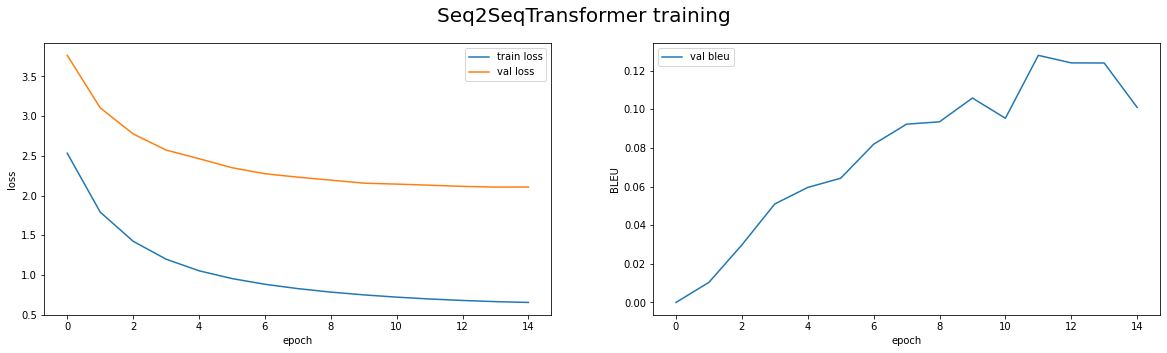

In [14]:
plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name='Seq2SeqTransformer training')

In [15]:
print("BLUE: ", val_bleu_list[-1], " Train Loss: ", train_loss_list[-1], " Val Loss: ", val_loss_list[-1])

BLUE:  0.10096431769375702  Train Loss:  0.6521564081533632  Val Loss:  2.1070357333141496


In [22]:
model_transformer.eval()
for i, batch in enumerate(val_dataloader):
    feature, target = batch
    with torch.no_grad():
        feature = feature[:10]
        target = target[:10]
        feature = feature.to(DEVICE)
        target = target.to(DEVICE)
        
        predicted_samples, _ = model_transformer.forward(feature)
        bleu_score, actual_sentences, predicted_sentences = model_transformer.eval_bleu(predicted_samples, target)
    print("BLUE: ", bleu_score)
    for orig, actual, pred in zip(feature, actual_sentences, predicted_sentences):
        print("Original: ", data_manager.source_tokenizer.decode(orig.tolist()))
        print("Actual: ", actual)
        print("Predicted: ", pred)
        print("--------------------------------------------")
    break
    

words_predicted:  ['я', 'лучше', 'тебе', 'тебе', 'об', 'об', 'этом', 'этом', 'этом']
words_actual:  ['я', 'лучше', 'не', 'буду', 'тебе', 'об', 'этом', 'сейчас', 'рассказывать']
words_predicted:  ['все', 'переиз', 'из', 'из']
words_actual:  ['внезапно', 'сотрудник', 'вышел', 'из', 'себя']
words_predicted:  ['я', 'тебе', 'ещё', 'ещё', 'снова', 'ещё', 'ещё', 'ещё', 'снова']
words_actual:  ['сколько', 'раз', 'тебе', 'повторял', 'будь', 'осторожнее']
words_predicted:  ['я', 'не', 'могу', 'продолжить', 'игнорировать', 'игнорировать']
words_actual:  ['я', 'не', 'могу', 'и', 'дальше', 'игнорировать', 'проблему']
words_predicted:  ['я', 'устал', 'слушать', 'его', 'его', 'речь']
words_actual:  ['я', 'устал', 'слушать', 'его', 'долгую', 'речь']
words_predicted:  ['том', 'вытащил', 'конверт', 'конверт', 'от', 'куртку']
words_actual:  ['том', 'вытащил', 'конверт', 'из', 'кармана', 'своей', 'куртки']
words_predicted:  ['насчёт', 'примерно', 'одной', 'из', 'земля', 'земля', 'земля', 'земля', 'земли',

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [8]:
data_config = yaml.load(open("configs/data_config.yaml", 'r'), Loader=yaml.Loader)
data_config

{'prefix_filter': [],
 'max_length': 15,
 'filename': 'rus.txt',
 'train_size': 0.8,
 'batch_size': 128,
 'pretrained_tokenizer': 'google-t5/t5-small'}

In [9]:
data_manager_t5 = DataManager(data_config, DEVICE)
train_dataloader_t5, val_dataloader_t5 = data_manager_t5.prepare_data()
target_tokenizer = data_manager_t5.target_tokenizer

Reading from file: 100%|██████████| 496059/496059 [00:06<00:00, 76031.93it/s]
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
model_config = yaml.load(open("configs/model_config.yaml", "r"), Loader=yaml.Loader)
model_config

{'learning_rate': 0.0003,
 'epoch_num': 7,
 'pretrained_name': 'google-t5/t5-small',
 'try_one_batch': False}

In [11]:
model_t5 = Seq2SeqT5(
    pretrained_name=model_config['pretrained_name'],
    encoder_vocab_size=len(data_manager_t5.source_tokenizer.word2index),
    decoder_vocab_size=len(data_manager_t5.target_tokenizer.word2index),
    lr=model_config['learning_rate'],
    target_tokenizer=target_tokenizer,
    device=DEVICE,
    T=model_config['epoch_num'] * len(train_dataloader_t5),
    start_symbol=target_tokenizer.tokenizer.pad_token
)

logger_t5 = TXTLogger("training_log_t5")
trainer_t5 = trainer.Trainer(model=model_t5, model_config=model_config, logger=logger_t5)

In [12]:
if model_config['try_one_batch']:
    train_dataloader_t5 = [list(train_dataloader_t5)[0]]
    val_dataloader_t5 = [list(val_dataloader_t5)[0]]

In [ ]:
trainer_t5.train(train_dataloader_t5, val_dataloader_t5)

  0%|          | 0/7 [00:00<?, ?it/s]/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


words_predicted:  ['ороо', 'то', 'ои']
words_actual:  ['мне', 'овело', 'вит', 'осле', 'несастноо', 'слуа']
words_predicted:  ['мо', 'дом', 'вседа', 'ат', 'ко']
words_actual:  ['кад', 'ра', 'кода', 'мимо', 'роеает', 'руовик', 'мо', 'дом', 'сотрсаетс']
words_predicted:  ['скаи', 'нам', 'оалуста', 'то']
words_actual:  ['расскаите', 'нам', 'оалуста', 'то', 'ниуд', 'о', 'сее']
words_predicted:  ['том', 'вес', 'ден', 'сидел', 'о', 'во']
words_actual:  ['том', 'вес', 'ден', 'сидит', 'а', 'комтером']
words_predicted:  ['аи', 'моу', 'лаат', 'на']
words_actual:  ['имане', 'моут', 'росатс', 'камнми', 'кода', 'увствут', 'уроу']
words_predicted:  ['он', 'оеал', 'а', 'то', 'л', 'в']
words_actual:  ['он', 'ривлекал', 'внимание', 'своим', 'костмом']
words_predicted:  ['он', 'не', 'моет', 'остановит', 'курит']
words_actual:  ['он', 'не', 'в', 'состонии', 'росит', 'курит']
words_predicted:  ['том', 'и', 'мри', 'оа', 'то', 'е']
words_actual:  ['том', 'и', 'мри', 'т', 'одно', 'и', 'то', 'е']
words_predict

 14%|█▍        | 1/7 [24:43<2:28:19, 1483.30s/it]

words_predicted:  ['т', 'скаал', 'то', 'ое', 'у']
words_actual:  ['т', 'е', 'оворил', 'то', 'ое', 'услат', 'равду']
words_predicted:  ['моет', 'не', 'уду', 'уитс']
words_actual:  ['вомоно', 'и', 'несастен', 'но', 'руки', 'на', 'се', 'накладват', 'не', 'соирас']
words_predicted:  ['аа', 'ороо', 'аиа']
words_actual:  ['воду', 'состоит', 'в', 'основном', 'и', 'аота', 'и', 'кислорода']
words_predicted:  ['том', 'дествително', 'не', 'оет']
words_actual:  ['том', 'не', 'оен', 'то', 'оет', 'то', 'ему', 'омоал']
Current BLEU:  0.06315801131626292
мне овело вит осле несастноо слуа ---> ороо то ои
кад ра кода мимо роеает руовик мо дом сотрсаетс ---> мо дом вседа ат ко
расскаите нам оалуста то ниуд о сее ---> скаи нам оалуста то
том вес ден сидит а комтером ---> том вес ден сидел о во
имане моут росатс камнми кода увствут уроу ---> аи моу лаат на
##############################
words_predicted:  ['том', 'одрол', 'мри', 'короер']
words_actual:  ['том', 'ротнул', 'мри', 'конверт', 'и', 'она', 'открл

/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


words_predicted:  ['то', 'ло', 'росто', 'ем', 'оо']
words_actual:  ['то', 'ло', 'рое', 'ем', 'каалос', 'на', 'ерв', 'влд']
words_predicted:  ['у', 'тома', 'два', 'сн', 'один', 'то', 'вра']
words_actual:  ['у', 'тома', 'два', 'сна', 'один', 'вра', 'друо', 'адвокат']
words_predicted:  ['роло', 'три', 'дн', 'дод']
words_actual:  ['оследние', 'три', 'дн', 'идт', 'дод']
words_predicted:  ['команду', 'рилас', 'дест']
words_actual:  ['комитет', 'состоит', 'и', 'дести', 'ленов']
words_predicted:  ['тот', 'аасов', 'ороа']
words_actual:  ['то', 'роисествие', 'орои', 'ример', 'ео', 'есености']
words_predicted:  ['л', 'оти', 'ути', 'но', 'том']
words_actual:  ['соиралс', 'уодит', 'но', 'рил', 'том', 'и', 'осталс']
words_predicted:  ['том', 'оворит', 'то', 'ланирует']
words_actual:  ['том', 'оворит', 'то', 'ланирует', 'оеат', 'в', 'остон', 'с', 'мри']
words_predicted:  ['у', 'мен', 'увству', 'то', 'т']
words_actual:  ['у', 'мен', 'такое', 'увство', 'то', 'у', 'те', 'ло', 'то', 'то', 'друое', 'на', 

 29%|██▊       | 2/7 [49:35<2:04:02, 1488.53s/it]

words_predicted:  ['если', 'тее', 'не', 'нравитс', 'о']
words_actual:  ['если', 'он', 'тее', 'не', 'нравитс', 'оему', 'т', 'с', 'ним', 'оворил']
words_predicted:  ['криа', 'ривт', 'аи', 'и']
words_actual:  ['кролики', 'родственники', 'оров', 'и', 'елок']
words_predicted:  ['она', 'думала', 'то', 'он', 'моет']
words_actual:  ['она', 'думала', 'то', 'он', 'вомоно', 'увствует', 'се', 'одиноким', 'и', 'атм']
words_predicted:  ['еловек', 'остраиваетс']
words_actual:  ['тело', 'еловека', 'состоит', 'и', 'миллиардов', 'мелаи', 'клеток']
words_predicted:  ['том', 'наконе', 'то', 'л', 'рила']
words_actual:  ['оло', 'неоото', 'том', 'наконе', 'соласилс', 'на', 'редлоение']
words_predicted:  ['аметил', 'если', 'ниуд']
words_actual:  ['аметил', 'если', 'ео', 'ниуд', 'недоставало']
Current BLEU:  0.072745486102845
том ротнул мри конверт и она открла ео ---> том одрол мри короер
олдвас наад дума то мне следовало оодитс с не олее ува ---> риен мне надо ло
ивините но отел скаат е ту новост лиом к лиу 

/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


 ['ин', 'неески', 'аин']
words_actual:  ['норвеские', 'трм', 'саме', 'росконе', 'в', 'мире']
words_predicted:  ['том', 'риеал', 'в', 'австрали', 'и']
words_actual:  ['том', 'риеал', 'в', 'австрали', 'в', 'оиска', 'ново', 'ини']
words_predicted:  ['отел', 'оти', 'но', 'у']
words_actual:  ['отел', 'оти', 'но', 'у', 'мен', 'росто', 'нет', 'времени']
words_predicted:  ['оеал', 'в', 'телевио', 'то']
words_actual:  ['оел', 'в', 'театр', 'то', 'осмотрет', 'современну', 'драму']
words_predicted:  ['мне', 'надо', 'ути', 'отому']
words_actual:  ['долен', 'идти', 'мен', 'там', 'на', 'улие', 'дут']
words_predicted:  ['не', 'асто', 'тоо', 'уе']
words_actual:  ['не', 'уверен', 'в', 'том', 'на', 'сто', 'роентов']
words_predicted:  ['давно', 'не', 'алс', 'о']
words_actual:  ['мен', 'уе', 'давно', 'ерестало', 'аотит', 'то', 'думает', 'том']
words_predicted:  ['оследни', 'ра', 'видел', 'как']
words_actual:  ['кода', 'видел', 'тома', 'в', 'оследни', 'ра', 'он', 'ел', 'локо']
words_predicted:  ['том', 'ив

 43%|████▎     | 3/7 [1:14:28<1:39:21, 1490.35s/it]

words_actual:  ['не', 'роснус', 'дае', 'если', 'авуит', 'тревоа']
words_predicted:  ['како', 'автра', 'удет', 'тем']
words_actual:  ['кака', 'автра', 'удет', 'темература']
words_predicted:  ['он', 'талс', 'уедит', 'и']
words_actual:  ['он', 'талс', 'уедит', 'и', 'в', 'свое', 'невиновности']
words_predicted:  ['оу', 'то', 'т', 'отве']
words_actual:  ['оу', 'то', 'т', 'вл', 'тома', 'с', 'соо', 'в', 'австрали']
words_predicted:  ['мне', 'нуно', 'оле', 'времени']
words_actual:  ['мне', 'нуно', 'оле', 'времени', 'то', 'аконит', 'доман', 'раоту']
words_predicted:  ['он', 'недостатоно', 'умн', 'то']
words_actual:  ['он', 'не', 'достатоно', 'умн', 'то', 'складват', 'исла', 'в', 'уме']
words_predicted:  ['о', 'том', 'не', 'нал', 'ока']
words_actual:  ['не', 'нал', 'о', 'том', 'ока', 'не', 'роел', 'аету']
words_predicted:  ['оворит', 'ден', 'толко', 'о']
words_actual:  ['оение', 'вес', 'ден', 'толко', 'на', 'рануском', 'ло', 'дл', 'мен', 'ороим', 'отом']
words_predicted:  ['оу', 'нат', 'кода', '

/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


words_predicted:  ['омоу', 'лди', 'куит', 'в']
words_actual:  ['омоа', 'лдм', 'окуат', 'веи', 'ере', 'интернет']
words_predicted:  ['сколко', 'у', 'тома', 'и', 'мри', 'дете']
words_actual:  ['сколко', 'у', 'тома', 'и', 'мри', 'дете']
words_predicted:  ['м', 'оеали', 'в', 'остон', 'де']
words_actual:  ['м', 'оеали', 'в', 'остон', 'де', 'роли', 'недел']
words_predicted:  ['т', 'дествително', 'думае']
words_actual:  ['дествително', 'думаете', 'то', 'а', 'то', 'имеет', 'смсл', 'алатит', 'тридат', 'долларов']
words_predicted:  ['инода', 'мат', 'ореала', 'волос']
words_actual:  ['инода', 'мат', 'одстриает', 'е', 'волос']
words_predicted:  ['она', 'думала', 'то', 'он', 'моет']
words_actual:  ['она', 'думала', 'то', 'он', 'вомоно', 'увствует', 'се', 'одиноким', 'и', 'атм']
words_predicted:  ['не', 'оу', 'то', 'лди']
words_actual:  ['не', 'оу', 'то', 'лди', 'о', 'том', 'нали']
words_predicted:  ['дума', 'он', 'то', 'то', 'имеет', 'к']
words_actual:  ['дума', 'он', 'имеет', 'какое', 'то', 'отное

 57%|█████▋    | 4/7 [1:39:19<1:14:32, 1490.92s/it]

words_predicted:  ['мо', 'комтер', 'дествително']
words_actual:  ['мо', 'комтер', 'идат', 'оен', 'странн', 'ум']
words_predicted:  ['овон', 'тее', 'как', 'тол']
words_actual:  ['овон', 'тее', 'срау', 'как', 'толко', 'уна', 'тоно']
words_predicted:  ['ниео', 'не', 'онл', 'то']
words_actual:  ['не', 'онл', 'ни', 'слова', 'и', 'тоо', 'то', 'т', 'скаал']
words_predicted:  ['мне', 'не', 'оетс', 'сеодн', 'в']
words_actual:  ['мне', 'сеодн', 'веером', 'не', 'оетс', 'идти', 'в', 'кино']
words_predicted:  ['том', 'иет', 'кто', 'то', 'оворит']
words_actual:  ['том', 'иет', 'коо', 'ниуд', 'кто', 'оворит', 'о', 'рануски']
words_predicted:  ['надес', 'твои', 'удуее']
words_actual:  ['надес', 'ваа', 'удуа', 'детелност', 'расирит', 'наи', 'отноени', 'с', 'вае', 'ирмо']
words_predicted:  ['дума', 'том', 'не', 'оен']
words_actual:  ['дума', 'то', 'том', 'не', 'оен', 'орои', 'еве']
words_predicted:  ['не', 'оен', 'ороо', 'ом']
words_actual:  ['у', 'мен', 'не', 'оен', 'ороо', 'с', 'аоминанием', 'имн']
wo

/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


words_predicted:  ['том', 'ее', 'оворит', 'о', 'ра']
words_actual:  ['том', 'орадо', 'луе', 'оворит', 'о', 'рануски', 'ем', 'мри']
words_predicted:  ['том', 'вседа', 'л', 'отлинм', 'от']
words_actual:  ['том', 'вседа', 'отлиалс', 'от', 'друи', 'дете']
words_predicted:  ['м', 'оен', 'мало', 'наем', 'о']
words_actual:  ['м', 'оен', 'мало', 'наем', 'о', 'риина', 'то', 'олени']
words_predicted:  ['том', 'ол', 'в', 'мааин', 'то']
words_actual:  ['том', 'ол', 'в', 'мааин', 'куит', 'масла']
words_predicted:  ['риина', 'оар', 'е', 'не', 'ра']
words_actual:  ['риина', 'оара', 'до', 'си', 'ор', 'не', 'установлена']
words_predicted:  ['том', 'куда', 'ниуд', 'ол', 'и']
words_actual:  ['том', 'куда', 'то', 'уодил', 'и', 'толко', 'то', 'вернулс']
words_predicted:  ['дума', 'том', 'орадо', 'л']
words_actual:  ['о', 'моему', 'том', 'от', 'орадо', 'луе', 'мри']
words_predicted:  ['ен', 'ремени', 'аставила']
words_actual:  ['ескровна', 'револи', 'в', 'оду', 'ривела', 'к', 'ораовани', 'конституионно', 'м

 71%|███████▏  | 5/7 [2:04:11<49:42, 1491.06s/it]  

words_predicted:  ['мне', 'нуно', 'нат', 'оему']
words_actual:  ['мне', 'нуно', 'нат', 'оему', 'тома', 'не', 'ло', 'сеодн', 'в', 'коле']
words_predicted:  ['том', 'роводит', 'мноо', 'времени', 'у']
words_actual:  ['том', 'тратит', 'массу', 'времени', 'на', 'истку', 'своео', 'ру']
words_predicted:  ['остроит', 'арков', 'арков']
words_actual:  ['на', 'остроку', 'арка', 'равлеени', 'отреовалос', 'дест', 'лет']
words_predicted:  ['слал', 'т', 'ие', 'нов']
words_actual:  ['оворт', 'т', 'ие', 'новоо', 'ассистента']
words_predicted:  ['том', 'сделал', 'то', 'ниуд', 'дл']
words_actual:  ['том', 'сделал', 'вс', 'дл', 'свое', 'сестр', 'мри']
words_predicted:  ['он', 'ринимает', 'равилно', 'встат']
words_actual:  ['он', 'вл', 'сее', 'а', 'равило', 'кадое', 'утро', 'встават', 'в', 'ест']
words_predicted:  ['лл', 'а', 'на', 'автрак']
words_actual:  ['лл', 'на', 'автрак', 'а', 'а', 'мо', 'сестра', 'редоитает', 'овсну', 'кау']
words_predicted:  ['если', 'о', 'не', 'ло', 'то']
words_actual:  ['если', 

/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


words_predicted:  ['том', 'сеас', 'ант', 'моно', 'те']
words_actual:  ['том', 'сеас', 'ант', 'моу', 'вам', 'ем', 'то', 'омо']
words_predicted:  ['не', 'дума', 'то', 'кто', 'то', 'оте']
words_actual:  ['мневас', 'то', 'кому', 'то', 'аоетс', 'ереитват', 'ту', 'книу']
words_predicted:  ['том', 'реил', 'роводит', 'в', 'том']
words_actual:  ['том', 'реил', 'в', 'том', 'оду', 'ровести', 'отуск', 'в', 'австралии']
words_predicted:  ['како', 'руака', 'тее', 'луе']
words_actual:  ['кака', 'руака', 'тее', 'оле', 'нравитс', 'красна', 'или', 'син']
words_predicted:  ['том', 'дес', 'не', 'вает', 'с', 'ро']
words_actual:  ['том', 'не', 'л', 'дес', 'с', 'ролоо', 'онеделника']
words_predicted:  ['том', 'вс', 'е', 'смоет', 'то', 'сдела']
words_actual:  ['моет', 'ли', 'том', 'о', 'ренему', 'делат', 'то', 'осле', 'оераии']
words_predicted:  ['том', 'налил', 'немноо', 'ое']
words_actual:  ['том', 'налил', 'в', 'аку', 'китку']
words_predicted:  ['ерв', 'ра', 'не', 'лил', 'ко']
words_actual:  ['кода', 'ерв'

 86%|████████▌ | 6/7 [2:29:02<24:51, 1491.01s/it]

words_predicted:  ['у', 'тома', 'ло', 'треуество', 'ко']
words_actual:  ['у', 'тома', 'ли', 'неоодиме', 'навки', 'то', 'усено', 'сделат', 'раоту']
words_predicted:  ['мо', 'каелн', 'иник', 'на']
words_actual:  ['мо', 'кассетн', 'манитоон', 'треует', 'ремонта']
words_predicted:  ['ест', 'мноо', 'орои', 'ри']
words_actual:  ['ест', 'мноо', 'вески', 'риин', 'тоо', 'не', 'делат']
words_predicted:  ['оему', 'т', 'росто', 'не', 'ку']
words_actual:  ['оему', 'т', 'не', 'куил', 'тот', 'котор', 'тее', 'онравилс']
words_predicted:  ['не', 'риоди', 'в', 'мо', 'комнате']
words_actual:  ['не', 'води', 'ко', 'мне', 'в', 'комнату', 'е', 'стука']
words_predicted:  ['в', 'илиотеке', 'никоо', 'нет']
words_actual:  ['сеас', 'в', 'илиотеке', 'нет', 'никоо', 'итаео']
words_predicted:  ['т', 'не', 'думае', 'то', 'нам', 'на']
words_actual:  ['тее', 'не', 'каетс', 'то', 'нам', 'о', 'кране', 'мере', 'следует', 'овонит', 'тому']
words_predicted:  ['некоторе', 'студент', 'ли', 'и']
words_actual:  ['некоторе', 'и

/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


words_predicted:  ['иираирование', 'ла', 'оен']
words_actual:  ['индустриалиаи', 'окаала', 'олое', 'влиние', 'на', 'равитие', 'кономики', 'онии']
words_predicted:  ['том', 'вно', 'не', 'оен', 'оро']
words_actual:  ['оевидно', 'том', 'не', 'оен', 'ороо', 'онимает', 'рануски']
words_predicted:  ['том', 'уверен', 'то', 'мри', 'моет']
words_actual:  ['том', 'уверен', 'то', 'мри', 'моет', 'о', 'сее', 'оаотитс']
words_predicted:  ['не', 'на', 'оему', 'встреа']
words_actual:  ['не', 'на', 'оему', 'совеание', 'ло', 'отлоено']
words_predicted:  ['не', 'моу', 'одорит', 'то']
words_actual:  ['мне', 'невносима', 'мсл', 'о', 'том', 'то', 'моу', 'те', 'отерт']
words_predicted:  ['то', 'том', 'скаал', 'мне', 'то', 'сдела']
words_actual:  ['то', 'том', 'скаал', 'мне', 'то', 'сделат']
words_predicted:  ['том', 'отел', 'то', 'у', 'нео']
words_actual:  ['тому', 'аотелос', 'имет', 'достатоно', 'средств', 'то', 'уволитс']
words_predicted:  ['то', 'росто', 'ворос', 'времени']
words_actual:  ['то', 'ли', 'во

100%|██████████| 7/7 [2:53:54<00:00, 1490.61s/it]

words_predicted:  ['т', 'думал', 'то', 'ое', 'на']
words_actual:  ['т', 'вроде', 'оворил', 'то', 'ое', 'науитс', 'то', 'делат']
words_predicted:  ['давно', 'иу', 'раоту']
words_actual:  ['иу', 'раоту', 'уе', 'долое', 'врем']
words_predicted:  ['то', 'сам', 'амеателн']
words_actual:  ['то', 'сам', 'удивителн', 'одарок', 'и', 'все', 'то', 'мне', 'риодилос', 'олуат']
words_predicted:  ['сделал', 'то', 'но', 'т', 'мен']
words_actual:  ['сделал', 'то', 'но', 'т', 'мен', 'оередил']
words_predicted:  ['том', 'мноо', 'именилс', 'с']
words_actual:  ['том', 'силно', 'именилс', 'с', 'те', 'ор', 'как', 'в', 'оследни', 'ра', 'ео', 'видел']
words_predicted:  ['отел', 'о', 'м', 'то', 'о']
words_actual:  ['мне', 'отелос', 'с', 'тоо', 'кое', 'о', 'м', 'ооворит']
words_predicted:  ['они', 'овинили', 'реидент', 'в']
words_actual:  ['они', 'овинили', 'реидента', 'в', 'ералиии', 'к', 'ростому', 'еловеку']
words_predicted:  ['мо', 'три', 'ода', 'до', 'оро']
words_actual:  ['мо', 'трлетн', 'до', 'оросила', '

In [ ]:
DATAPATH = 'training_log_t5'
progress_file_path = os.path.join(DATAPATH, "progress_log.txt")
file_content = open(progress_file_path, 'r').read().split("\n")

In [ ]:
train_loss_list, val_loss_list, val_bleu_list = [], [], []
for line in file_content:
    d = extract_values(line)
    if len(d) > 0:
        train_loss_list.append(d['train_loss'])
        val_loss_list.append(d['val_loss'])
        val_bleu_list.append(d['bleu_score'])
    
        
len(train_loss_list), len(val_loss_list), len(val_bleu_list)

(7, 7, 7)

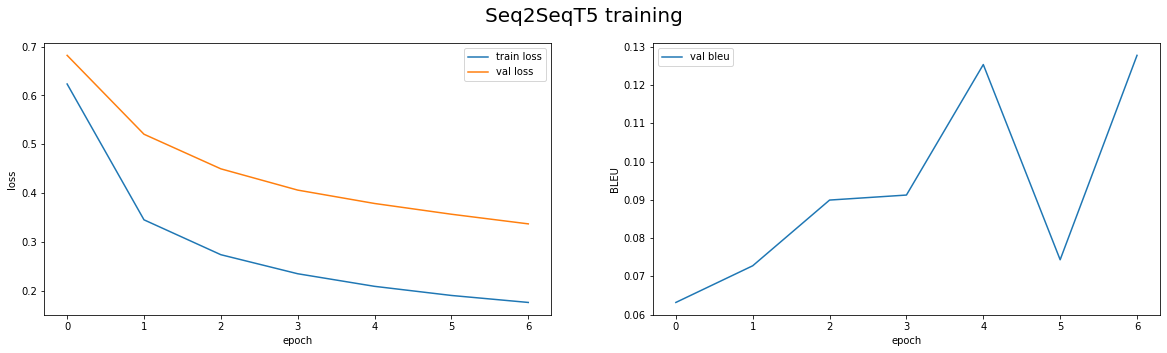

In [ ]:
plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name='Seq2SeqT5 training')

In [ ]:
print("BLUE: ", val_bleu_list[-1], " Train Loss: ", train_loss_list[-1], " Val Loss: ", val_loss_list[-1])

BLUE:  0.12775418356576704  Train Loss:  0.17571239190463403  Val Loss:  0.33673891733842065


In [ ]:
model_t5.eval()
for i, batch in enumerate(val_dataloader_t5):
    feature, target, attention_mask = batch
    with torch.no_grad():
        feature = feature[0]
        target = target[0]
        feature = feature.to(DEVICE)
        target = target.to(DEVICE)
        attention_mask = attention_mask[0]
        attention_mask = attention_mask.to(DEVICE)
        samples = torch.IntTensor([feature.tolist(), attention_mask.tolist()]).to(DEVICE)
        
        predicted_samples = model_t5.generate(samples, None)
        
        print("Original: ", data_manager_t5.source_tokenizer.decode(target.tolist()))
        print("Actual: ", data_manager_t5.source_tokenizer.decode(feature.tolist()))
        print("Predicted: ", data_manager_t5.source_tokenizer.decode(predicted_samples[0]))
        print("--------------------------------------------")

    if i > 9:
        break
    

/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
2024-05-13 01:11:52.764845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Original:  ['оему', 'в', 'не', 'отите', 'с', 'нами', 'ооедат']
Actual:  ['why', 'don', 't', 'you', 'want', 'to', 'eat', 'lunch', 'with', 'us']
Predicted:  ['оему', 'т', 'не', 'ое', 'с']
--------------------------------------------


/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Original:  ['т', 'не', 'нал', 'то', 'том', 'едет', 'в', 'австрали']
Actual:  ['didn', 't', 'you', 'know', 'that', 'tom', 'was', 'going', 'to', 'australia']
Predicted:  ['т', 'не', 'нал', 'то', 'том', 'едет']
--------------------------------------------
Original:  ['медсестра', 'наоила', 'олноо', 'аелсиновм', 'соком', 'ере', 'стеклнну', 'труоку']
Actual:  ['the', 'nurse', 'gave', 'the', 'patient', 'his', 'orange', 'juice', 'through', 'a', 'glass', 'tube']
Predicted:  ['медсестра', 'дала', 'аиенту', 'а']
--------------------------------------------


/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Original:  ['ео', 'отка', 'ерелт', 'реку', 'не', 'увеналас', 'усеом']
Actual:  ['he', 'failed', 'in', 'his', 'attempt', 'to', 'swim', 'across', 'the', 'river']
Predicted:  ['он', 'не', 'оталс', 'ерел']
--------------------------------------------


/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Original:  ['о', 'сооени', 'новосте', 'он', 'л', 'седен', 'акулами']
Actual:  ['according', 'to', 'the', 'news', 'he', 'was', 'eaten', 'by', 'sharks']
Predicted:  ['о', 'новости', 'ео', 'ели', 'акури']
--------------------------------------------


/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Original:  ['кода', 'онадоитс', 'т', 'мое', 'рити', 'ко', 'мне']
Actual:  ['when', 'it', 's', 'necessary', 'you', 'can', 'come', 'to', 'me']
Predicted:  ['кода', 'то', 'неоодимо', 'мое']
--------------------------------------------


/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Original:  ['в', 'том', 'саду', 'мноо', 'камне']
Actual:  ['there', 'are', 'lots', 'of', 'rocks', 'in', 'this', 'garden']
Predicted:  ['в', 'том', 'саду', 'мноо', 'камен']
--------------------------------------------


/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Original:  ['т', 'не', 'мо', 'расскаат', 'мне', 'то', 'ниуд', 'о', 'свое', 'семе']
Actual:  ['could', 'you', 'tell', 'me', 'something', 'about', 'your', 'family']
Predicted:  ['т', 'не', 'мо', 'мне', 'то', 'ни']
--------------------------------------------


/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Original:  ['если', 'он', 'осталс', 'в', 'тот', 'ден', 'дома', 'то', 'не', 'оал', 'в', 'еду']
Actual:  ['if', 'he', 'had', 'stayed', 'at', 'home', 'that', 'day', 'he', 'would', 'not', 'have', 'met', 'with', 'disaster']
Predicted:  ['если', 'он', 'л', 'сеодн', 'до']
--------------------------------------------


/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Original:  ['ест', 'лди', 'которе', 'думат', 'то', 'ананас', 'растут', 'од', 'емл']
Actual:  ['there', 'are', 'people', 'who', 'think', 'pineapples', 'grow', 'underground']
Predicted:  ['лди', 'думат', 'то', 'анан']
--------------------------------------------


/home/jupyter/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Original:  ['том', 'не', 'рареит', 'мри', 'оти', 'на', 'вееринку', 'с', 'доном']
Actual:  ['tom', 'won', 't', 'permit', 'mary', 'to', 'go', 'to', 'the', 'party', 'with', 'john']
Predicted:  ['том', 'не', 'оволит', 'мри', 'о']
--------------------------------------------
